## LETS WORK TOWARD ITERROWS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
%load_ext line_profiler
from tqdm import tqdm

windows = False # If on mac put false, windows true

#### data input

In [2]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_met.csv", index_col=0) # FOR WINDOWS
    
    pickle_in = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_pt_averaged.pickle",'rb')
    baseline_pt_averaged = pickle.load(pickle_in)
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines/baselines_met.csv", index_col=0) # FOR MAC
    
    pickle_in = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines/baselines_pt_averaged.pickle",'rb')
    baseline_pt_averaged = pickle.load(pickle_in)

#### paramaters

In [3]:
#outside params, _o stands for original
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
# M_o = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/mL #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper
K_o = 5e-8 #µL/(mm*s*mmHg) #payne paper and boas et al
alpha_t = 2.6e-5 #mL_O2/(mL*mmHg) from payne paper, solutbility coeff of oxygen in brain tissue

#convert param to my SU
M_constant = 8.20e-4 # cm3_O2/(cm3*s) , still unsure about the exact conversion so will just input in this section
K = K_o * (1e6) # µm2/(s*mmHg)

#model input params
delay_pressure_drop = 4
time_for_drop = 1
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
ratio_drop = 0.5
hill_constant = 2 # mmHg
# kp_constant = 1/300 # s-1
kp_constant = 1/300 # s-1
kn_constant = 1/600 # s-1

#loop info
# no = 1000001 #12501
# max_time = 400
no = 2000001 #12501
max_time = 400

#### work out vectors

In [4]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)
drop_value = 60 - 34.18*ratio_drop

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    elif t[i] <= delay_pressure_drop + time_for_drop:
        pressure_in[i] = 60 - ((t[i] - delay_pressure_drop)/time_for_drop)*(60-drop_value)
    else:
        pressure_in[i] = drop_value
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

print('Time of simulation :',max_time,'seconds')
print('Time vessels :',dt,'seconds')
print('Number of iterations:',no)

Time of simulation : 400 seconds
Time vessels : 0.0002 seconds
Number of iterations: 2000001


## Model

#### Functions

In [5]:
def total_R(baselines,phi,alpha):
    """Calculates the resistance of the network.
    
    """
    
    C_ = alpha*(baselines.at[6,'Resistance for Q']/2)/phi**4  + (1-alpha)*(baselines.at[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.at[5,'Resistance for Q'] + baselines.at[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.at[4,'Resistance for Q'] + baselines.at[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.at[3,'Resistance for Q'] + baselines.at[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.at[2,'Resistance for Q'] + baselines.at[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.at[1,'Resistance for Q'] + baselines.at[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.at[0,'Resistance for Q'] + baselines.at[12,'Resistance for Q']
    R_total = C_654321
    return R_total
 
def check_imag_roots_real(two_roots):
    """Takes two imaginary roots from the Servinghaus equation and returns the real one.
    
    Will print if there is an error.
    Returns real root."""
    
    counter = 0
    sols = 0
    for i in range(len(two_roots)):
        if two_roots[i].imag <= 10e-13 and two_roots[i].imag >= -10e-13:
            sols = two_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols

def master(alpha,delay,baselines):
    """Entire model.
    
    """  
    ###Set up
    
    delay_number = round(delay/dt) #finds nearest index to the 
    no_vessels = 13
    
    network = pd.DataFrame()
    network['t'] = t
    network['pressure_difference'] = pressure_difference
    network['phi'] = pd.Series(np.zeros(no))
    network['phi_min'] = pd.Series(np.zeros(no))
    network['dphidt'] = pd.Series(np.zeros(no))
    network['R_tot'] = pd.Series(np.zeros(no))
    network['Q_tot'] = pd.Series(np.zeros(no))
    network['Q_norm'] = pd.Series(np.zeros(no))
    network['pt_averaged'] = pd.Series(np.zeros(no))
    
    network['pt_averaged_50'] = pd.Series(np.zeros(no))
    network['pt_averaged_5'] = pd.Series(np.zeros(no))
    network['kp_p'] = pd.Series(np.zeros(no))
    network['kp_n'] = pd.Series(np.zeros(no))
    network['dApdt'] = pd.Series(np.zeros(no))
    network['Ap'] = pd.Series(np.zeros(no))
    network['dDpdt'] = pd.Series(np.zeros(no))
    network['Dp'] = pd.Series(np.zeros(no))
    
    ### Initialise values
    
    network.at[0,'phi'] = 1
    network.at[0,'phi_min'] = 1
    network.at[0,'dphidt'] = 0
    network.at[0,'Ap'] = 1
    network.at[0,'Dp'] = 0
    network.at[0,'pt_averaged'] = baseline_pt_averaged # kind of a bit of a different way to the rest. So I can embed the new parts where they should be in for loop.
    
    pt_averaged_50 = baseline_pt_averaged*0.5
    pt_averaged_5 = baseline_pt_averaged*0.1
    
    R = 1
    k = 0.1
    tau_c = 1/600 #s-1
    c_baseline = R/(1+k)
    network.at[0,'c'] = c_baseline
    c_50 = c_baseline*10
    c_5 = c_baseline
    network.at[0,'An'] = 1
    network.at[0,'Dn'] = 0
    
    
    for i in tqdm(range(len(t))):
        """For each time step:
        
        """  
        ### Update network paramaters
        
        network.at[i,'R_tot'] = total_R(baselines,network.at[i,'phi'],alpha)
        network.at[i,'Q_tot'] = network.at[i,'pressure_difference']/network.at[i,'R_tot']
        network.at[i,'Q_norm'] = network.at[i,'Q_tot'] / baselines['Q in single(µm3/s)'][0]
        
        #New bits:
        network.at[i,'kp_p'] = (kp_constant/2)*(1-np.tanh( (network.at[i,'pt_averaged']-pt_averaged_50) / pt_averaged_5))
        network.at[i,'kp_n'] = (kp_constant/2)*(1+np.tanh( (network.at[i,'pt_averaged']-pt_averaged_50) / pt_averaged_5 ))
        network.at[i,'dApdt'] = -network.at[i,'kp_p']*network.at[i,'Ap'] + network.at[i,'kp_n']*(1-network.at[i,'Ap']-network.at[i,'Dp'])
        network.at[i,'dDpdt'] = network.at[i,'kp_p']*(1-network.at[i,'Ap']-network.at[i,'Dp'])
        
        network.at[i,'kn_p'] = (kn_constant/2)*(1+np.tanh( (network.at[i,'c']-c_50) / c_5))
        network.at[i,'kn_n'] = (kn_constant/2)*(1-np.tanh( (network.at[i,'c']-c_50) / c_5 ))
        network.at[i,'dAndt'] = -network.at[i,'kn_p']*network.at[i,'An'] + network.at[i,'kn_n']*(1-network.at[i,'An']-network.at[i,'Dn'])
        network.at[i,'dDndt'] = network.at[i,'kn_p']*(1-network.at[i,'An']-network.at[i,'Dn'])
        
        network.at[i,'dcdt'] = (1/tau_c)*(R-network.at[i,'c']*(k+network.at[i,'Q_norm']))
 

        if i-delay_number <0: # As cant index before 0 as not initialised for that.
            network.at[i,'dphidt'] =  (1/optimised_value_tau)*( - 1 + network.at[i,'Q_norm']*(1-network.at[i,'phi_min']) + network.at[i,'phi_min'] )
        else:
            network.at[i,'dphidt'] =  (1/optimised_value_tau)*( -network.at[i-delay_number,'phi'] + network.at[i,'Ap']*(network.at[i,'Q_norm']*(1-network.at[i,'phi_min']) + network.at[i,'phi_min']) )
            
        #Euler    
        network.at[i+1,'phi'] = network.at[i,'dphidt']*dt + network.at[i,'phi']
        network.at[i+1,'phi_min'] = 1-(alpha**0.25)*(1-phi_min_baseline)*(1-network.at[i,'Q_norm'])**n  
        
        network.at[i+1,'Ap'] = network.at[i,'dApdt']*dt + network.at[i,'Ap']   
        network.at[i+1,'Dp'] = network.at[i,'dDpdt']*dt + network.at[i,'Dp']  
        
        network.at[i+1,'An'] = network.at[i,'dAndt']*dt + network.at[i,'An']   
        network.at[i+1,'Dn'] = network.at[i,'dDndt']*dt + network.at[i,'Dn']  
        network.at[i+1,'c'] = network.at[i,'dcdt']*dt + network.at[i,'c']  
        #### Update Vessel paramaters
        
        # Euler from previous model. Necessary for: ...
        if i == 0:                                  
            vessels = first_iteration.copy()
        else:
            vessels = vessel_data_alltime[i-1].copy()
            #Following works as I have loaded in previous values. Then updateding for the new ones Forwards Euler.
            vessels['tissue partials(mmHg)'] = vessels['tissue partials(mmHg)'] + vessels['dptdt']*dt
            vessels['Saturation out'] = vessels['Saturation out'] + vessels['dSoutdt']*dt
            vessels['Saturation in'] = vessels['Saturation in'] + vessels['dSindt']*dt 
#             vessels['Sav'] = vessels['Sav'] + vessels['dSavdt']*dt
        #Update other values for new flow
        vessels.at[6,'Diameter(µm)'] = baseline.at[6,'Diameter(µm)']*network.at[i,'phi']    
        vessels.at[6,'X-Area wall(???)'] = np.pi * ( 0.16*(vessels.at[6,'Diameter(µm)'])**2 + 1.4*(vessels.at[6,'Diameter(µm)']) + 14 )
        vessels.at[6,'wall thickness(µm)'] = ( -(vessels.at[6,'Diameter(µm)']) + np.sqrt((vessels.at[6,'Diameter(µm)'])**2 + (4*(vessels.at[6,'X-Area wall(???)'])/np.pi))) / 2
        vessels['Sav'] = (vessels['Saturation in']+vessels['Saturation out'])/2
        vessels['M'] = (network.at[i,'An'])*M_constant*vessels['tissue partials(mmHg)']/(vessels['tissue partials(mmHg)']+hill_constant)
        for j in range(no_vessels):
            root_temp = None
            sols = 0
            root_temp = np.roots([1,0,150,23400*vessels.at[j,'Sav']/(vessels.at[j,'Sav']-1)]) #gives mmHg
            sols = check_imag_roots_real(root_temp) 
            vessels.at[j,'partial pressure blood(mmHg)'] = sols    
        #Could just do the flow update as ratio of previous flow to new flow then times previous values by this ratio as all flows scale linearly.
        vessels['Q in single(µm3/s)'] = vessels['Q in single(µm3/s)']*network.at[i,'Q_norm']
        
#         for j in range(no_vessels):
#             if j == 0:
#                 vessels.at[j,'dS'] = 2*(1-vessels.at[j,'Sav'])
#             else:
#                 vessels.at[j,'dS'] = 2*(vessels.at[j-1,'Sav'] - vessels.at[j,'Sav']) - vessels.at[j-1,'dS']
        
#         vessels['dSavdt'] = 0.5 * (2/(np.pi*((vessels['Diameter(µm)']**2)/4)*vessels['Length(µm)'])) \
#                             * ( - (2 * np.pi * K * (vessels['Diameter(µm)']/2) * constant['Length(µm)'])/(vessels['wall thickness(µm)']*cHb*H) \
#                             * (vessels['partial pressure blood(mmHg)']-vessels['tissue partials(mmHg)'])\
#                             - vessels['Q in single(µm3/s)']*vessels['dS'] )\
        
        for j in range(len(vessels)):
            """For each vessel
            Update Q in single based on updated Q_tot
            Calculate dSoutdt and make this dSindt for next vessel."""
            #Could definitely get rid of this by not updating. I ahve all the values I realistically need with one column. Just for completeness. Could just have dSoutdt for each vessel and know this is thenext ones dSinDt. and know for A1 is is 0.
            if j ==0:
                vessels.at[j,'dSindt'] = 0
            else:
                vessels.at[j,'dSindt'] = vessels.at[j-1,'dSoutdt']

            vessels.at[j,'dSoutdt'] = 2/(np.pi*((vessels.at[j,'Diameter(µm)']**2)/4)*vessels.at[j,'Length(µm)']) \
                                    * ( - (2 * np.pi * K * (vessels.at[j,'Diameter(µm)']/2) * constant.at[j,'Length(µm)'])/(vessels.at[j,'wall thickness(µm)']*cHb*H) \
                                    * (vessels.at[j,'partial pressure blood(mmHg)']-vessels.at[j,'tissue partials(mmHg)'])\
                                    - vessels.at[j,'Q in single(µm3/s)']*(vessels.at[j,'Saturation out']-vessels.at[j,'Saturation in']) )\
                                    - vessels.at[j,'dSindt']
            
        ### The main show: calculating dpdt and other useful representations.
        
        vessels['dptdt'] = (1/(alpha_t*constant['Vt(µm3)']))\
                        *(((2 * np.pi * K * (vessels['Diameter(µm)']/2) * constant['Length(µm)'])/(vessels['wall thickness(µm)']))\
                        *(vessels['partial pressure blood(mmHg)']-vessels['tissue partials(mmHg)'])\
                        - vessels['M'] * constant['Vt(µm3)'])
        vessels['pt_by_Vt'] = vessels['tissue partials(mmHg)'] * vessels['Vt(µm3)']

        network.at[i+1,'pt_averaged'] = vessels['pt_by_Vt'].sum()/13 ###### BADDDDDDd

        ### Save vessels to a dictionary
        
        vessel_data_alltime[i] = vessels
    
    ### To let you know whether it managed to run all the way through.
    
    if i == no-1:
        print('finished')
    else:
        print('broken')
    
    return network, vessel_data_alltime

#### Clean up baselines

#### the loop

100%|██████████| 2000001/2000001 [13:49:19<00:00, 40.19it/s]         


finished
min: 0.005582559602421659
final: 0.006349313752209528


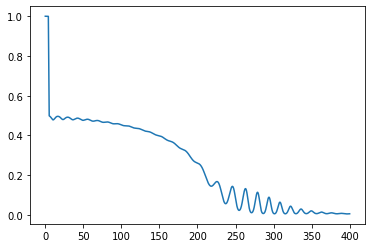

In [6]:
# Initialise Data, set up DFs
# baseline = baselines.drop(['Viscocity(mmHg*s)','Resistance for U', 'U in single(µm/s)'],axis=1).rename(columns={'Saturation ave': 'Sav'})
# first_iteration = baseline.loc[:,['Name','Number','Diameter(µm)','Length(µm)','dS','Sav','Resistance for Q','Q in single(µm3/s)','Vt(µm3)','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)']].assign(dptdt = np.zeros(len(baseline)),dSavdt = np.zeros(len(baseline)))
# constant = baseline.drop(['Q in single(µm3/s)','Pressure Drop(mmHg)','Saturation in','Saturation out','Resistance for Q','dS','Sav','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)'], axis=1)
# vessel_data_alltime = {}
# pt_averaged = pd.Series(np.zeros(len(t)))
# terms_data_alltime = {}

baseline = baselines.drop(['Viscocity(mmHg*s)','Resistance for U', 'U in single(µm/s)'],axis=1).rename(columns={'Saturation ave': 'Sav'})
first_iteration = baseline.loc[:,['Name','Number','Diameter(µm)','Length(µm)','Saturation in','Saturation out','Sav','Resistance for Q','Q in single(µm3/s)','Vt(µm3)','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)']].assign(dptdt = np.zeros(len(baseline)))
constant = baseline.drop(['Q in single(µm3/s)','Pressure Drop(mmHg)','Saturation in','Saturation out','Resistance for Q','dS','Sav','partial pressure blood(mmHg)','X-Area wall(???)','wall thickness(µm)','tissue partials(mmHg)'], axis=1)
vessel_data_alltime = {}
pt_averaged = pd.Series(np.zeros(len(t)))
terms_data_alltime = {}

alpha = 0.2
delay = 2.99



# %timeit euler2(alpha,delay,baselines)

# %timeit -r 10 -n 1 run()
        
# %prun -s cumulative run()

# %lprun -f master master(alpha,delay,baselines)

N,V_alltime = master(alpha,delay,baselines)
plt.plot(N['t'],N['Q_norm'])
print('min:',min(N['Q_norm']))
print('final:', N.at[len(N)-2,'Q_norm'])

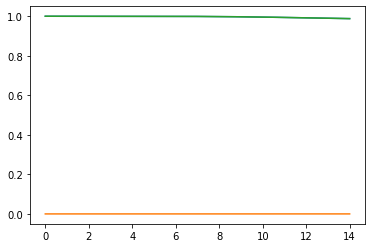

In [35]:
# plt.plot(N['t'],N['pt_averaged'])
# plt.plot(N['t'],N['pt_averaged']/N.at[0,'pt_averaged'])
# min(N['pt_averaged']/N.at[0,'pt_averaged'])
plt.plot(N['t'],N['Ap'])
plt.plot(N['t'],N['Dp'])
plt.plot(N['t'],N['Ap'])

In [18]:
N

,t,pressure_difference,phi,phi_min,dphidt,R_tot,Q_tot,Q_norm,pt_averaged,pt_averaged_50,...,dDpdt,Dp,c,An,Dn,kn_p,kn_n,dAndt,dDndt,dcdt
0,0.00000,34.18,1.000000,1.000000,0.000000e+00,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,0.000000e+00,0.000000e+00,0.909091,1.000000,0.000000e+00,2.538330e-11,0.001667,-2.538330e-11,0.000000e+00,0.210804
1,0.00015,34.18,1.000000,0.999725,-4.639531e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,5.391729e-13,0.000000e+00,0.909123,1.000000,0.000000e+00,2.538507e-11,0.001667,-2.538506e-11,9.582248e-26,0.189941
2,0.00030,34.18,1.000000,0.999725,-4.639531e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,1.078346e-12,8.087594e-17,0.909151,1.000000,1.437337e-29,2.538666e-11,0.001667,-2.538664e-11,1.916570e-25,0.171144
3,0.00045,34.18,1.000000,0.999725,-4.639531e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,1.617518e-12,2.426278e-16,0.909177,1.000000,4.312192e-29,2.538809e-11,0.001667,-2.538807e-11,2.875017e-25,0.154206
4,0.00060,34.18,1.000000,0.999725,-4.639531e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,2.156690e-12,4.852555e-16,0.909200,1.000000,8.624718e-29,2.538938e-11,0.001667,-2.538936e-11,3.833551e-25,0.138945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999997,599.99955,17.09,0.039034,0.287782,-1.301745e-04,0.151900,1.125081e+02,0.000030,4.092751e-06,0.0,...,9.042804e-04,5.927656e-01,9.996971,0.582482,1.075695e-01,1.466826e-03,0.000200,-7.924596e-04,4.546403e-04,0.000040
3999998,599.99970,17.09,0.039034,0.287782,-1.301744e-04,0.151900,1.125079e+02,0.000030,4.092751e-06,0.0,...,9.042802e-04,5.927657e-01,9.996971,0.582482,1.075696e-01,1.466826e-03,0.000200,-7.924594e-04,4.546403e-04,0.000040
3999999,599.99985,17.09,0.039034,0.287782,-1.301744e-04,0.151901,1.125076e+02,0.000030,4.092752e-06,0.0,...,9.042800e-04,5.927659e-01,9.996971,0.582482,1.075696e-01,1.466826e-03,0.000200,-7.924593e-04,4.546404e-04,0.000040
4000000,600.00000,17.09,0.039034,0.287782,-1.301743e-04,0.151901,1.125074e+02,0.000030,4.092752e-06,0.0,...,9.042797e-04,5.927660e-01,9.996971,0.582482,1.075697e-01,1.466826e-03,0.000200,-7.924591e-04,4.546405e-04,0.000040


In [21]:
def plot_param(column_name,normal = 0):
    df = None
    string = None
    df = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
    for i in tqdm(range(len(vessel_data_alltime))):
        for j in range(len(vessel_data_alltime[0])):
            df.iloc[i,j] = vessel_data_alltime[i].at[j,column_name]
    fig,ax = plt.subplots(figsize=(10,8))
    if normal == 1:
        df_normal =  pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
                       'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
        for i in range(len(vessel_data_alltime[0])):
            df_normal.iloc[:,i] = df.iloc[:,i] / baseline.at[i,column_name]
        column_name = column_name + 'normal'
        scale = df_normal.iloc[0,0] / pressure_difference[0]
        plt.plot(t,scale*(pressure_difference),label='pressure in', color='0.8')
        plt.ylim(0,1.1)
    for i in range(13):
        if normal ==0:
            plt.plot(t,df.iloc[:,i], label=vessel_data_alltime[0].at[i,'Name'])
        elif normal ==1:
            plt.plot(t,df_normal.iloc[:,i], label=vessel_data_alltime[0].at[i,'Name'])
        else:
            print('error')
    ax.legend()
    plt.grid(which='both')
    string = column_name + ' against time'
    plt.ylabel(column_name)
    plt.xlabel('time /s')
    plt.title(string, fontsize=20)
    
# plot_param('partial pressure blood(mmHg)')
plot_param('partial pressure blood(mmHg)',1)
# # plot_param('tissue partials(mmHg)')
plot_param('tissue partials(mmHg)',1)
# plot_param('Saturation in')
# plot_param('Saturation out')
# plot_param('pt_averaged')
# plot_param('Q in single(µm3/s)')
# plot_param('Q in single(µm3/s)',1)
# plot_param('dptdt')
# plot_param('dSoutdt')
# plot_param('dSindt')
# plot_param('dSavdt')
# plot_param('Sav')
# plot_param('dS')

  3%|▎         | 127918/4000001 [06:05<4:31:16, 237.90it/s]

KeyboardInterrupt: 

  3%|▎         | 127918/4000001 [06:20<4:31:16, 237.90it/s]

In [ ]:
save = True
if save == True:
    if windows == True:
        pickle_out = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\12_combine_pt_euler\vessels_first_long_run.pickle",'wb')
        pickle.dump(Valltime, pickle_out)
        pickle_out.close()
        print('1 done')
        
        pickle_out2 = open(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\12_combine_pt_euler\network_first_long_runpickle",'wb')
        pickle.dump(N, pickle_out2)
        pickle_out2.close()
    else:
        pickle_out = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/12_combine_pt_euler\vessels_first_long_run.pickle",'wb')
        pickle.dump(V_alltime, pickle_out)
        pickle_out.close()
        
        pickle_out2 = open(r"/Users/Debs/OneDrive - Nexus365/4YP/python/12_combine_pt_euler\network_first_long_run.pickle",'wb')
        pickle.dump(N, pickle_out2)
        pickle_out2.close()
#### CHANGE TO BASELINES WITHIN FOLDER. this means i dont need to worry about changing baselines for later calcls unless i absolutely want to

In [26]:
min(N['Q_norm'])

0.40146469786344946

In [59]:
print('final:', N.at[len(N)-2,'Q_norm'])

final: 0.4740659919836162


In [70]:
hi

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Viscocity(mmHg*s),Resistance for U,Resistance for Q,U in single(µm/s),Q in single(µm3/s),dS,Sav,partial pressure blood(mmHg),X-Area wall(???),wall thickness(µm),tissue partials(mmHg),Vt(µm3)
0,A1,1,23.97,1267.6,6.93,0.9400,0.9300,0.000012,0.000842,1.866110e-06,8229.436888,3.713608e+06,0.0100,0.93500,68.843131,438.213672,4.841407,65.678837,3.920026e+06
1,A2,2,19.17,930.3,5.87,0.9300,0.9200,0.000011,0.000912,3.158317e-06,6439.441736,1.858585e+06,0.0100,0.92500,65.327798,313.016429,4.253658,62.957193,1.964399e+06
2,A3,4,15.28,543.6,4.02,0.9200,0.8900,0.000011,0.000794,4.328170e-06,5065.066367,9.287990e+05,0.0300,0.90500,59.809062,228.546291,3.810683,52.973057,2.962124e+06
3,A4,8,12.08,302.3,2.70,0.8900,0.8400,0.000010,0.000666,5.814403e-06,4051.677394,4.643641e+05,0.0500,0.86500,52.183980,170.463521,3.485850,40.331980,2.496394e+06
4,A5,16,9.46,161.2,1.82,0.8400,0.7650,0.000010,0.000553,7.874816e-06,3288.204541,2.311165e+05,0.0750,0.80250,44.546726,130.572935,3.265971,24.694563,1.919460e+06
5,A6,32,7.32,154.7,2.35,0.7650,0.6650,0.000009,0.000852,2.025728e-05,2756.606465,1.160077e+05,0.1000,0.71500,37.579012,103.110791,3.138293,20.386542,1.304955e+06
6,C,64,8.00,243.9,2.62,0.6650,0.6100,0.000009,0.002269,4.513708e-05,1154.776548,5.804540e+04,0.0550,0.63750,33.077299,111.338044,3.172168,30.301779,3.486216e+05
7,V6,32,11.51,473.9,1.27,0.6100,0.5975,0.000010,0.001142,1.097658e-05,1111.977986,1.157009e+05,0.0125,0.60375,31.395007,161.197683,3.433626,30.908155,1.577403e+05
8,V5,16,14.53,272.3,0.61,0.5975,0.5875,0.000011,0.000433,2.614226e-06,1407.231531,2.333386e+05,0.0100,0.59250,30.861700,214.009514,3.730525,29.685171,2.551342e+05
9,V4,8,17.79,426.6,0.89,0.5875,0.5825,0.000011,0.000479,1.926676e-06,1858.401329,4.619354e+05,0.0050,0.58500,30.512889,281.309064,4.092089,29.846912,2.524554e+05


In [59]:
baselines

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Viscocity(mmHg*s),Resistance for U,Resistance for Q,U in single(µm/s),Q in single(µm3/s),dS,Saturation ave,partial pressure blood(mmHg),X-Area wall(???),wall thickness(µm),tissue partials(mmHg),Vt(µm3)
0,A1,1,23.97,1267.6,6.93,0.9400,0.9300,0.000012,0.000842,1.866110e-06,8229.436888,3.713608e+06,0.0100,0.93500,68.843131,438.213672,4.841407,65.678837,3.920026e+06
1,A2,2,19.17,930.3,5.87,0.9300,0.9200,0.000011,0.000912,3.158317e-06,6439.441736,1.858585e+06,0.0100,0.92500,65.327798,313.016429,4.253658,62.957193,1.964399e+06
2,A3,4,15.28,543.6,4.02,0.9200,0.8900,0.000011,0.000794,4.328170e-06,5065.066367,9.287990e+05,0.0300,0.90500,59.809062,228.546291,3.810683,52.973057,2.962124e+06
3,A4,8,12.08,302.3,2.70,0.8900,0.8400,0.000010,0.000666,5.814403e-06,4051.677394,4.643641e+05,0.0500,0.86500,52.183980,170.463521,3.485850,40.331980,2.496394e+06
4,A5,16,9.46,161.2,1.82,0.8400,0.7650,0.000010,0.000553,7.874816e-06,3288.204541,2.311165e+05,0.0750,0.80250,44.546726,130.572935,3.265971,24.694563,1.919460e+06
5,A6,32,7.32,154.7,2.35,0.7650,0.6650,0.000009,0.000852,2.025728e-05,2756.606465,1.160077e+05,0.1000,0.71500,37.579012,103.110791,3.138293,20.386542,1.304955e+06
6,C,64,8.00,243.9,2.62,0.6650,0.6100,0.000009,0.002269,4.513708e-05,1154.776548,5.804540e+04,0.0550,0.63750,33.077299,111.338044,3.172168,30.301779,3.486216e+05
7,V6,32,11.51,473.9,1.27,0.6100,0.5975,0.000010,0.001142,1.097658e-05,1111.977986,1.157009e+05,0.0125,0.60375,31.395007,161.197683,3.433626,30.908155,1.577403e+05
8,V5,16,14.53,272.3,0.61,0.5975,0.5875,0.000011,0.000433,2.614226e-06,1407.231531,2.333386e+05,0.0100,0.59250,30.861700,214.009514,3.730525,29.685171,2.551342e+05
9,V4,8,17.79,426.6,0.89,0.5875,0.5825,0.000011,0.000479,1.926676e-06,1858.401329,4.619354e+05,0.0050,0.58500,30.512889,281.309064,4.092089,29.846912,2.524554e+05


In [73]:
hi = baselines.rename(columns={'Saturation ave': 'Sav'})
hi.assign(dptdt = np.zeros(len(baseline)),dSavdt = np.zeros(len(baseline)))

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Viscocity(mmHg*s),Resistance for U,Resistance for Q,...,Q in single(µm3/s),dS,Sav,partial pressure blood(mmHg),X-Area wall(???),wall thickness(µm),tissue partials(mmHg),Vt(µm3),dptdt,dSavdt
0,A1,1,23.97,1267.6,6.93,0.9400,0.9300,0.000012,0.000842,1.866110e-06,...,3.713608e+06,0.0100,0.93500,68.843131,438.213672,4.841407,65.678837,3.920026e+06,0.0,0.0
1,A2,2,19.17,930.3,5.87,0.9300,0.9200,0.000011,0.000912,3.158317e-06,...,1.858585e+06,0.0100,0.92500,65.327798,313.016429,4.253658,62.957193,1.964399e+06,0.0,0.0
2,A3,4,15.28,543.6,4.02,0.9200,0.8900,0.000011,0.000794,4.328170e-06,...,9.287990e+05,0.0300,0.90500,59.809062,228.546291,3.810683,52.973057,2.962124e+06,0.0,0.0
3,A4,8,12.08,302.3,2.70,0.8900,0.8400,0.000010,0.000666,5.814403e-06,...,4.643641e+05,0.0500,0.86500,52.183980,170.463521,3.485850,40.331980,2.496394e+06,0.0,0.0
4,A5,16,9.46,161.2,1.82,0.8400,0.7650,0.000010,0.000553,7.874816e-06,...,2.311165e+05,0.0750,0.80250,44.546726,130.572935,3.265971,24.694563,1.919460e+06,0.0,0.0
5,A6,32,7.32,154.7,2.35,0.7650,0.6650,0.000009,0.000852,2.025728e-05,...,1.160077e+05,0.1000,0.71500,37.579012,103.110791,3.138293,20.386542,1.304955e+06,0.0,0.0
6,C,64,8.00,243.9,2.62,0.6650,0.6100,0.000009,0.002269,4.513708e-05,...,5.804540e+04,0.0550,0.63750,33.077299,111.338044,3.172168,30.301779,3.486216e+05,0.0,0.0
7,V6,32,11.51,473.9,1.27,0.6100,0.5975,0.000010,0.001142,1.097658e-05,...,1.157009e+05,0.0125,0.60375,31.395007,161.197683,3.433626,30.908155,1.577403e+05,0.0,0.0
8,V5,16,14.53,272.3,0.61,0.5975,0.5875,0.000011,0.000433,2.614226e-06,...,2.333386e+05,0.0100,0.59250,30.861700,214.009514,3.730525,29.685171,2.551342e+05,0.0,0.0
9,V4,8,17.79,426.6,0.89,0.5875,0.5825,0.000011,0.000479,1.926676e-06,...,4.619354e+05,0.0050,0.58500,30.512889,281.309064,4.092089,29.846912,2.524554e+05,0.0,0.0


In [75]:
len(hi)

13

In [ ]:
baseliens

In [8]:
N

,t,pressure_difference,phi,phi_min,dphidt,R_tot,Q_tot,Q_norm,pt_averaged,pt_averaged_50,...,dDpdt,Dp,c,An,Dn,kn_p,kn_n,dAndt,dDndt,dcdt
0,0.0000,34.18,1.000000,1.000000,0.000000e+00,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,0.000000e+00,0.000000e+00,0.909091,1.000000,0.000000e+00,2.538330e-11,0.001667,-2.538330e-11,0.000000e+00,0.210804
1,0.0002,34.18,1.000000,0.999781,-3.689683e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,4.579924e-18,0.000000e+00,0.909133,1.000000,0.000000e+00,2.538565e-11,0.001667,-2.538565e-11,1.296452e-25,0.182987
2,0.0004,34.18,1.000000,0.999781,-3.689683e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,9.159848e-18,9.159848e-22,0.909170,1.000000,2.592904e-29,2.538770e-11,0.001667,-2.538768e-11,2.593113e-25,0.158841
3,0.0006,34.18,1.000000,0.999781,-3.689683e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,1.373977e-17,2.747954e-21,0.909201,1.000000,7.779129e-29,2.538947e-11,0.001667,-2.538945e-11,3.889941e-25,0.137882
4,0.0008,34.18,1.000000,0.999781,-3.689683e-08,0.000009,3.712173e+06,0.999614,6.494201e+07,0.0,...,1.831970e-17,5.495909e-21,0.909229,1.000000,1.555901e-28,2.539101e-11,0.001667,-2.539098e-11,5.186902e-25,0.119688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999997,399.9994,17.09,0.118483,0.437173,1.251003e-03,0.000725,2.357827e+04,0.006349,2.550226e-06,0.0,...,1.175302e-03,3.802669e-01,9.403358,0.927860,2.777666e-03,1.108976e-03,0.000558,-9.902921e-04,7.692094e-05,-0.023513
1999998,399.9996,17.09,0.118483,0.437173,1.250927e-03,0.000725,2.357847e+04,0.006349,2.550226e-06,0.0,...,1.175302e-03,3.802671e-01,9.403353,0.927860,2.777681e-03,1.108972e-03,0.000558,-9.902879e-04,7.692088e-05,-0.023512
1999999,399.9998,17.09,0.118483,0.437173,1.250851e-03,0.000725,2.357867e+04,0.006349,2.550226e-06,0.0,...,1.175302e-03,3.802674e-01,9.403349,0.927860,2.777697e-03,1.108968e-03,0.000558,-9.902838e-04,7.692082e-05,-0.023511
2000000,400.0000,17.09,0.118483,0.437173,1.250776e-03,0.000725,2.357886e+04,0.006349,2.550226e-06,0.0,...,1.175301e-03,3.802676e-01,9.403344,0.927860,2.777712e-03,1.108964e-03,0.000558,-9.902796e-04,7.692075e-05,-0.023509


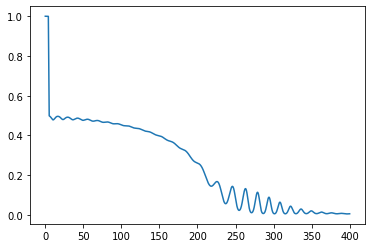

In [9]:
plt.plot(N['t'],N['Q_norm'])